In [37]:
# import libraries
import requests
import time
from datetime import datetime
import json
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)  #allows display of all columns in dfs


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
colors = ["#118AB2", "#EF476F", "#FFD166", "#06D6A0", "#EE754D", "#002E99"]
#plt.style.use('seaborn-whitegrid')

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

In [2]:
# mysql login info
sys.path.insert(0, '../../Key')
from mysql_secret import dbuser, dbpass, dbhost, dbname
engine = create_engine(f'mysql://{dbuser}:{dbpass}@{dbhost}/{dbname}?charset=utf8')

In [3]:
def flatten_cols(df):
    df.columns = [
        '_'.join(tuple(map(str, t))).strip() 
        for t in df.columns.values
        ]
    return df

# Performance Analysis

In [79]:
connection = engine.connect()
ipo_df = pd.read_sql("SELECT * FROM ipo_tracker.vw_stocks_performance", connection)
connection.close()
ipo_df.head()

,symbol,company,proposed_share_price,shares_offered,dollar_val_shares,city,state,country,zip_code,industry,sector,date_of_market_cap,market_cap,market_cap_formatted,market_cap_classification,first_trade_date,first_trade_year,first_trade_month,first_trade_year_month,first_day_open,first_day_close,first_day_high,first_day_low,first_day_volume,date_most_recent,days_trading,most_recent_open,most_recent_close,date_7_days,open_7_days,close_7_days,date_30_days,open_30_days,close_30_days,date_60_days,open_60_days,close_60_days,date_90_days,open_90_days,close_90_days,date_180_days,open_180_days,close_180_days,date_365_days,open_365_days,close_365_days
0,AAAU,Goldman Sachs Physical Gold ETF,11.74,16286645,1.912052e+08,,,,,,,None,NaN,None,None,2018-08-15,2018,8,2018-08,11.84,11.74,11.84,11.74,27300,2020-12-24,862,18.65,18.71,2018-08-22,11.98,11.96,2018-09-14,12.01,11.93,2018-10-15,12.27,12.27,2018-11-13,11.99,12.00,2019-02-11,13.03,13.08,2019-08-15,15.14,15.21
1,AACQU,Artius Acquisition Inc.,10.00,63000000,6.300000e+08,None,None,None,None,None,None,None,NaN,None,None,2020-07-14,2020,7,2020-07,10.42,10.35,10.44,10.30,17017800,2020-12-24,163,11.23,11.20,2020-07-21,10.46,10.45,2020-08-13,10.17,10.15,2020-09-14,10.31,10.43,2020-10-12,10.19,10.24,None,NaN,NaN,None,NaN,NaN
2,ABCL,AbCellera Biologics Inc.,20.00,24150000,4.830000e+08,Vancouver,BC,Canada,V5Y 0A1,Biotechnology,Healthcare,2020-12-23,1.148835e+10,11.49B,Large-cap,2020-12-11,2020,12,2020-12,61.00,58.90,71.91,48.98,9249200,2020-12-24,13,43.26,42.42,2020-12-18,49.20,49.22,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
3,ABCM,Abcam PLC,17.50,8945218,1.565413e+08,Cambridge,,United Kingdom,CB2 0AX,Biotechnology,Healthcare,2020-12-24,4.557766e+09,4.56B,Mid-cap,2020-10-22,2020,10,2020-10,18.00,19.75,20.81,17.71,2471300,2020-12-24,63,20.26,20.30,2020-10-29,19.08,19.12,2020-11-23,18.70,18.44,2020-12-21,19.17,19.84,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
4,ABNB,"Airbnb, Inc.",68.00,51323531,3.490000e+09,San Francisco,CA,United States,94103,Internet Content & Information,Communication Services,2020-12-24,9.250889e+10,92.51B,Large-cap,2020-12-10,2020,12,2020-12,146.00,144.71,165.00,141.25,70447500,2020-12-24,14,159.16,154.84,2020-12-17,143.00,147.05,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN


## Sector and Industry

In [5]:
# remove stocks with None or blank as sector / industry
si_data_df = ipo_df[(ipo_df["industry"].notnull()) & (ipo_df["industry"] != "")
            & (ipo_df["sector"].notnull()) & (ipo_df["sector"] != "")]
si_data_df.head(2)

,symbol,company,proposed_share_price,shares_offered,dollar_val_shares,city,state,country,zip_code,industry,sector,date_of_market_cap,market_cap,market_cap_formatted,market_cap_classification,first_trade_date,first_trade_year,first_trade_month,first_trade_year_month,first_day_open,first_day_close,first_day_high,first_day_low,first_day_volume,date_most_recent,days_trading,most_recent_open,most_recent_close,date_7_days,open_7_days,close_7_days,date_30_days,open_30_days,close_30_days,date_60_days,open_60_days,close_60_days,date_90_days,open_90_days,close_90_days,date_180_days,open_180_days,close_180_days,date_365_days,open_365_days,close_365_days
2,ABCL,AbCellera Biologics Inc.,20.00,24150000,483000000.0,Vancouver,BC,Canada,V5Y 0A1,Biotechnology,Healthcare,2020-12-23,1.148835e+10,11.49B,Large-cap,2020-12-11,2020,12,2020-12,61.0,58.90,71.91,48.98,9249200,2020-12-24,13.0,43.26,42.42,2020-12-18,49.20,49.22,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN
3,ABCM,Abcam PLC,17.50,8945218,156541315.0,Cambridge,,United Kingdom,CB2 0AX,Biotechnology,Healthcare,2020-12-24,4.557766e+09,4.56B,Mid-cap,2020-10-22,2020,10,2020-10,18.0,19.75,20.81,17.71,2471300,2020-12-24,63.0,20.26,20.30,2020-10-29,19.08,19.12,2020-11-23,18.7,18.44,2020-12-21,19.17,19.84,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN


### Sector by Year

In [6]:
sector_by_year_df = si_data_df.pivot_table(index='sector', columns='first_trade_year', 
                                    aggfunc={"symbol": 'count'})
sector_by_year_df = sector_by_year_df.fillna(0).sort_values(by=sector_by_year_df.columns[-1], ascending=True)

# pass to function to flatten columns
sector_by_year_df = flatten_cols(sector_by_year_df)
sector_by_year_df


,symbol_2018,symbol_2019,symbol_2020
sector,,,
Energy,6.0,5.0,0.0
Utilities,1.0,1.0,0.0
Basic Materials,1.0,2.0,1.0
Industrials,13.0,4.0,5.0
Real Estate,6.0,5.0,9.0
Communication Services,12.0,12.0,10.0
Consumer Defensive,8.0,7.0,11.0
Consumer Cyclical,11.0,11.0,23.0
Technology,33.0,26.0,35.0


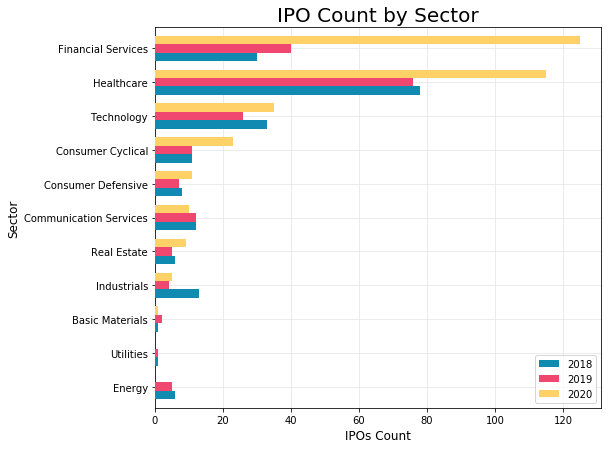

In [84]:
ax = sector_by_year_df.plot(kind="barh", figsize=(8,7), color=colors, zorder=3, width=0.75)
ax.grid(which="major", axis='both', color='#e6e6e6', zorder=0)
ax.legend([2018, 2019, 2020])
ax.set_ylabel(f'Sector', fontsize=12)
ax.set_xlabel(f'IPOs Count', fontsize=12)
ax.set_title("IPO Count by Sector", fontsize=20)
plt.show()

## Top Performing n Period

Values for analysis

In [45]:
# example stock to view
stock_symbol = 'ABCM' 

Data preparation

In [61]:
# add price change column
sa_df = ipo_df.copy()
sa_df["first_close_to_rec_close"] = sa_df["most_recent_close"] / sa_df["first_day_close"] - 1
sa_df.head(5)

,symbol,company,proposed_share_price,shares_offered,dollar_val_shares,city,state,country,zip_code,industry,sector,date_of_market_cap,market_cap,market_cap_formatted,market_cap_classification,first_trade_date,first_trade_year,first_trade_month,first_trade_year_month,first_day_open,first_day_close,first_day_high,first_day_low,first_day_volume,date_most_recent,days_trading,most_recent_open,most_recent_close,date_7_days,open_7_days,close_7_days,date_30_days,open_30_days,close_30_days,date_60_days,open_60_days,close_60_days,date_90_days,open_90_days,close_90_days,date_180_days,open_180_days,close_180_days,date_365_days,open_365_days,close_365_days,first_close_to_rec_close
0,AAAU,Goldman Sachs Physical Gold ETF,11.74,16286645,1.912052e+08,,,,,,,None,NaN,None,None,2018-08-15,2018,8,2018-08,11.84,11.74,11.84,11.74,27300,2020-12-24,862.0,18.65,18.71,2018-08-22,11.98,11.96,2018-09-14,12.01,11.93,2018-10-15,12.27,12.27,2018-11-13,11.99,12.00,2019-02-11,13.03,13.08,2019-08-15,15.14,15.21,0.593697
1,AACQU,Artius Acquisition Inc.,10.00,63000000,6.300000e+08,None,None,None,None,None,None,None,NaN,None,None,2020-07-14,2020,7,2020-07,10.42,10.35,10.44,10.30,17017800,2020-12-24,163.0,11.23,11.20,2020-07-21,10.46,10.45,2020-08-13,10.17,10.15,2020-09-14,10.31,10.43,2020-10-12,10.19,10.24,None,NaN,NaN,None,NaN,NaN,0.082126
2,ABCL,AbCellera Biologics Inc.,20.00,24150000,4.830000e+08,Vancouver,BC,Canada,V5Y 0A1,Biotechnology,Healthcare,2020-12-23,1.148835e+10,11.49B,Large-cap,2020-12-11,2020,12,2020-12,61.00,58.90,71.91,48.98,9249200,2020-12-24,13.0,43.26,42.42,2020-12-18,49.20,49.22,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,-0.279796
3,ABCM,Abcam PLC,17.50,8945218,1.565413e+08,Cambridge,,United Kingdom,CB2 0AX,Biotechnology,Healthcare,2020-12-24,4.557766e+09,4.56B,Mid-cap,2020-10-22,2020,10,2020-10,18.00,19.75,20.81,17.71,2471300,2020-12-24,63.0,20.26,20.30,2020-10-29,19.08,19.12,2020-11-23,18.70,18.44,2020-12-21,19.17,19.84,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,0.027848
4,ABNB,"Airbnb, Inc.",68.00,51323531,3.490000e+09,San Francisco,CA,United States,94103,Internet Content & Information,Communication Services,2020-12-24,9.250889e+10,92.51B,Large-cap,2020-12-10,2020,12,2020-12,146.00,144.71,165.00,141.25,70447500,2020-12-24,14.0,159.16,154.84,2020-12-17,143.00,147.05,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,0.070002


In [69]:
# get sector for stock of interest
stock_sector = sa_df.loc[sa_df["symbol"] == stock_symbol]["sector"].iloc[0]
print(f"{stock_symbol} is in the {stock_sector} sector")

# get industry for stock of interest
stock_industry = sa_df.loc[sa_df["symbol"] == stock_symbol]["industry"].iloc[0]
print(f"{stock_symbol} is in the {stock_industry} industry")

# get market cap classification for stock of interest
stock_market_cap = sa_df.loc[sa_df["symbol"] == stock_symbol]["market_cap_classification"].iloc[0]
print(f"{stock_symbol} is a {stock_market_cap} market cap")

ABCM is in the Healthcare sector
ABCM is in the Biotechnology industry
ABCM is a Mid-cap market cap


In [88]:
# create new columns for vizualization
# sector
conditions = [(sa_df["symbol"] == stock_symbol), (sa_df["sector"] == stock_sector)]
choices = [stock_symbol, stock_sector]
sa_df["Stock Sector"] = np.select(conditions, choices, "Other")

# industry
conditions = [(sa_df["symbol"] == stock_symbol), (sa_df["industry"] == stock_industry)]
choices = [stock_symbol, stock_industry]
sa_df["Stock Industry"] = np.select(conditions, choices, "Other")

# market cap
conditions = [(sa_df["symbol"] == stock_symbol), (sa_df["industry"] == stock_market_cap)]
choices = [stock_symbol, stock_market_cap]
sa_df["Stock Market Cap"] = np.select(conditions, choices, "Other")

sa_df.head(2)

,symbol,company,proposed_share_price,shares_offered,dollar_val_shares,city,state,country,zip_code,industry,sector,date_of_market_cap,market_cap,market_cap_formatted,market_cap_classification,first_trade_date,first_trade_year,first_trade_month,first_trade_year_month,first_day_open,first_day_close,first_day_high,first_day_low,first_day_volume,date_most_recent,days_trading,most_recent_open,most_recent_close,date_7_days,open_7_days,close_7_days,date_30_days,open_30_days,close_30_days,date_60_days,open_60_days,close_60_days,date_90_days,open_90_days,close_90_days,date_180_days,open_180_days,close_180_days,date_365_days,open_365_days,close_365_days,first_close_to_rec_close,Stock Sector,Stock Market Cap,Stock Industry
0,AAAU,Goldman Sachs Physical Gold ETF,11.74,16286645,191205212.0,,,,,,,None,NaN,None,None,2018-08-15,2018,8,2018-08,11.84,11.74,11.84,11.74,27300,2020-12-24,862.0,18.65,18.71,2018-08-22,11.98,11.96,2018-09-14,12.01,11.93,2018-10-15,12.27,12.27,2018-11-13,11.99,12.00,2019-02-11,13.03,13.08,2019-08-15,15.14,15.21,0.593697,Other,Other,Other
1,AACQU,Artius Acquisition Inc.,10.00,63000000,630000000.0,None,None,None,None,None,None,None,NaN,None,None,2020-07-14,2020,7,2020-07,10.42,10.35,10.44,10.30,17017800,2020-12-24,163.0,11.23,11.20,2020-07-21,10.46,10.45,2020-08-13,10.17,10.15,2020-09-14,10.31,10.43,2020-10-12,10.19,10.24,None,NaN,NaN,None,NaN,NaN,0.082126,Other,Other,Other


In [94]:
# data for plotting sector in similar market cap
sa_mc_df = sa_df[sa_df["market_cap_classification"] == stock_market_cap]
sa_mc_df

,symbol,company,proposed_share_price,shares_offered,dollar_val_shares,city,state,country,zip_code,industry,sector,date_of_market_cap,market_cap,market_cap_formatted,market_cap_classification,first_trade_date,first_trade_year,first_trade_month,first_trade_year_month,first_day_open,first_day_close,first_day_high,first_day_low,first_day_volume,date_most_recent,days_trading,most_recent_open,most_recent_close,date_7_days,open_7_days,close_7_days,date_30_days,open_30_days,close_30_days,date_60_days,open_60_days,close_60_days,date_90_days,open_90_days,close_90_days,date_180_days,open_180_days,close_180_days,date_365_days,open_365_days,close_365_days,first_close_to_rec_close,Stock Sector,Stock Market Cap,Stock Industry
3,ABCM,Abcam PLC,17.50,8945218,156541315.0,Cambridge,,United Kingdom,CB2 0AX,Biotechnology,Healthcare,2020-12-24,4.557766e+09,4.56B,Mid-cap,2020-10-22,2020,10,2020-10,18.00,19.75,20.81,17.71,2471300,2020-12-24,63.0,20.26,20.30,2020-10-29,19.08,19.12,2020-11-23,18.70,18.44,2020-12-21,19.17,19.84,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,0.027848,ABCM,ABCM,ABCM
7,ACCD,"Accolade, Inc.",22.00,10022726,220499972.0,Plymouth Meeting,PA,United States,19462,Health Information Services,Healthcare,2020-12-24,2.885153e+09,2.89B,Mid-cap,2020-07-01,2020,7,2020-07,35.00,29.70,36.89,29.11,8507600,2020-12-24,176.0,55.36,52.42,2020-07-08,30.25,34.31,2020-07-31,33.66,32.44,2020-08-31,34.47,33.61,2020-09-29,36.32,38.42,None,NaN,NaN,None,NaN,NaN,0.764983,Healthcare,Other,Other
9,ACI,"Albertsons Companies, Inc.",16.00,50000000,800000000.0,Boise,ID,United States,83706,Grocery Stores,Consumer Defensive,2020-12-24,7.444282e+09,7.44B,Mid-cap,2020-06-26,2020,6,2020-06,15.50,15.45,16.50,15.31,37215600,2020-12-24,181.0,15.71,15.75,2020-07-06,15.78,15.52,2020-07-27,16.04,15.24,2020-08-25,14.60,14.59,2020-09-24,13.53,13.38,2020-12-23,15.90,15.55,None,NaN,NaN,0.019417,Other,Other,Other
13,ADCT,ADC Therapeutics SA,19.00,12245631,232666989.0,Epalinges,,Switzerland,1066,Biotechnology,Healthcare,2020-12-24,2.837823e+09,2.84B,Mid-cap,2020-05-18,2020,5,2020-05,30.00,30.00,30.99,29.73,819800,2020-12-24,220.0,36.50,36.99,2020-05-26,35.83,36.40,2020-06-17,38.96,39.10,2020-07-17,48.01,49.00,2020-08-17,39.87,38.62,2020-11-16,34.39,34.16,None,NaN,NaN,0.233000,Healthcare,Other,Biotechnology
16,ADPT,Adaptive Biotechnologies Corp,20.00,15000000,300000000.0,Seattle,WA,United States,98102,Biotechnology,Healthcare,2020-12-22,8.943548e+09,8.94B,Mid-cap,2019-06-27,2019,6,2019-06,39.49,40.30,40.62,36.21,11245600,2020-12-24,546.0,65.39,62.53,2019-07-05,39.30,40.51,2019-07-29,39.91,37.76,2019-08-26,43.75,44.19,2019-09-25,37.75,34.96,2019-12-24,30.45,30.00,2020-06-26,47.42,46.29,0.551613,Healthcare,Other,Biotechnology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,YALA,Yalla Group Ltd,7.50\t,18600000,139500000.0,Dubai,,United Arab Emirates,,Software—Application,Technology,2020-12-24,2.436345e+09,2.44B,Mid-cap,2020-09-30,2020,9,2020-09,9.75,7.00,10.99,6.98,13201000,2020-12-24,85.0,17.49,17.01,2020-10-07,7.60,8.08,2020-10-30,8.55,8.41,2020-11-30,11.00,15.41,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,1.430000,Other,Other,Other
772,YETI,"YETI Holdings, Inc.",18.00,16000000,288000000.0,Austin,TX,United States,78735,Leisure,Consumer Cyclical,2020-12-24,6.364844e+09,6.36B,Mid-cap,2018-10-25,2018,10,2018-10,16.75,17.00,17.45,16.48,9911600,2020-12-24,791.0,72.91,73.09,2018-11-01,16.09,16.16,2018-11-26,18.21,17.92,2018-12-24,12.60,12.51,2019-01-23,17.24,17.53,2019-04-23,31.40,31.64,2019-10-25,31.95,32.81,3.299412,Other,Other,Other
776,YMAB,"Y-mAbs Therapeutics, Inc.",16.00,6000000,96000000.0,New York,NY,United States,10169,Biotechnology,Healthcare,2020-12-24,2.167481e+09,2.17B,Mid-cap,2018-09-21,2018,9,2018-09,26.50,24.00,28.03,22.50,2481000,2020-12-24,825.0,54.28,53.50,2018-09-28,25.21,26.56,2018-10-22,21.48,21.93,2018-11-20,24.41,2

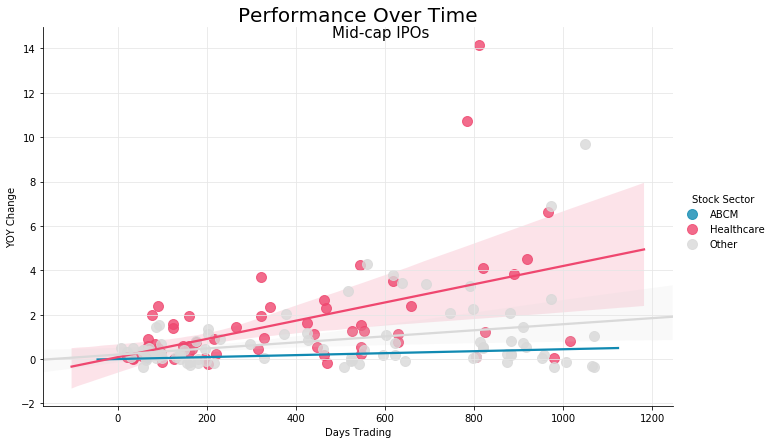

In [119]:
# Plot
colors = ["#118AB2", "#EF476F", "#d9d9d9"]
sns.lmplot('days_trading', 'first_close_to_rec_close', data=sa_mc_df, hue='Stock Sector', 
           palette=colors[0:3], scatter_kws={"s": 100}, fit_reg=True, height=6, aspect=1.6)
plt.title("Performance Over Time", fontsize=20)
plt.suptitle(f"{stock_market_cap} IPOs", fontsize=15)
plt.ylabel("YOY Change")
plt.xlabel("Days Trading")
plt.grid(which="major", axis='both', color='#e6e6e6', zorder=0)


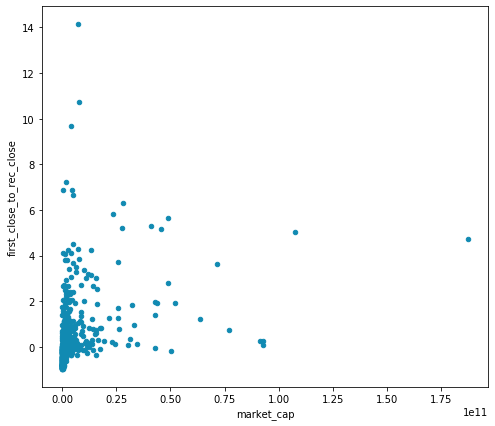

In [87]:
# remove stocks with None or blank as sector / industry
ax1 = sa_df.plot(kind="scatter", x="market_cap", y="first_close_to_rec_close", c=colors[0], figsize=(8,7), zorder=3)
ax.margins(0.05)

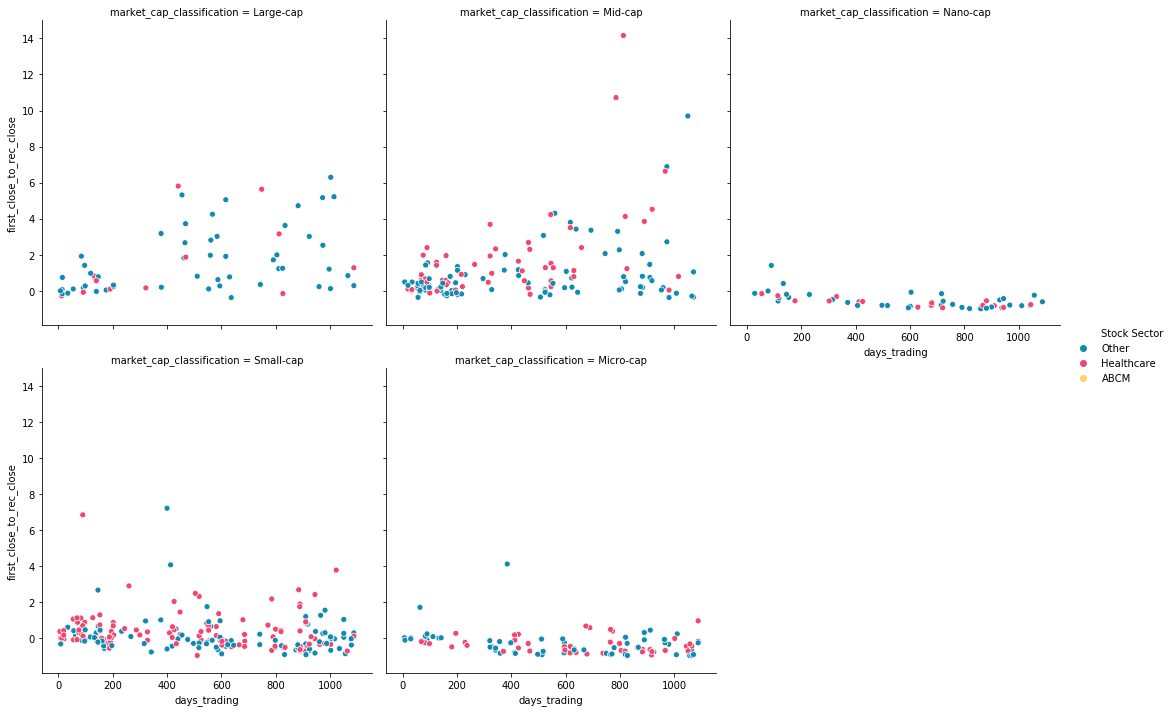

In [78]:
sns.relplot(
    data=sa_df,
    x="days_trading", y="first_close_to_rec_close", col="market_cap_classification", col_wrap=3,
    hue="Stock Sector", palette=colors[0:3]
)